In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.9 MB/s eta 0:00:00


# Load Data

In [ ]:
import pandas as pd
import torch
import numpy as np

from torch import nn
from transformers import BertModel

from torch.optim import Adam
from tqdm import tqdm

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/nzlul03/NLP-playground/main/BERT_playground/BBC_news_classification_using_BERT/bbc-text.csv')
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


<Axes: xlabel='category'>

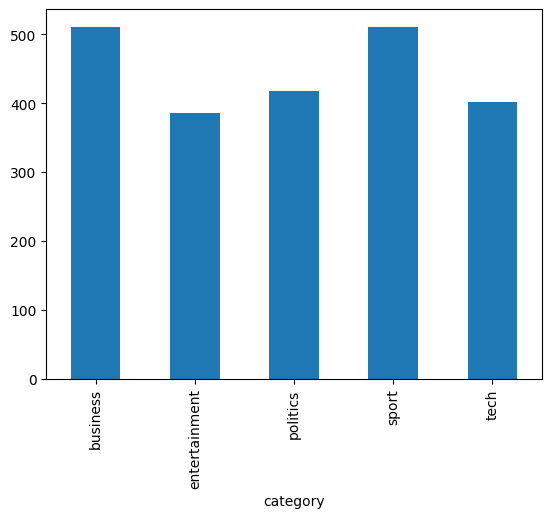

In [ ]:
df.groupby(['category']).size().plot.bar()

# Preprocessing Data



*   We need to transform our text into the format that BERT expects by adding [CLS] and [SEP] tokens.
*   We can do this easily with `BertTokenizer` class from Hugging Face.



To make it easier for us to understand the output that we get from `BertTokenizer`, let’s use a short text as an example

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
example_text = 'I will watch Momento tonight'
bert_input = tokenizer(example_text,
                       padding = 'max_length',
                       max_length = 10,
                       truncation = True,
                       return_tensors='pt')

In [ ]:
print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])

tensor([[  101,   146,  1209,  2824, 24334,  1186,  3568,   102,     0,     0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]])


The explanation of `BertTokenizer` parameters:
* `padding` : to pad each sequence to the maximum length that you specify.
* `max_length` : max length of each sequence.
* `truncation` : if True, then the tokens in each sequence that exceed the maximum length will be truncated
* `return_tensors` : the type of tensors that will be returned. Pytorch: `pt` and Tensorflow: `tf`.

The explanation of the BERT output:
* `input_ids` : the id representation of each token.
* `token_type_ids` : binary mask that identifies in which sequence a token belongs. If we have a single sequence, then all of the token type ids will be 0.

* !!! for text classification task, `token_type_ids` is an optional input for our BERT model.

* `attention_mask` : a binary mask that identifies whether a token is a real word or just padding. If the token contains any real word, [CLS], [SEP] then the mask would be 1. Meanwhile, if the token is just padding [PAD], then the mask would be 0.

# Dataset Class

In [ ]:
labels = {'business': 0,
          'entertainment': 1,
          'sport': 2,
          'tech': 3,
          'politics': 4}

* Build a `Dataset` class for our news dataset that will serve as a class to generate our news data.
* Notice that we also call `BertTokenizer` in the` __init__` function to transform our input texts into the format that BERT expects.


In [ ]:
class Dataset(torch.utils.data.Dataset):

  def __init__(self, df):

    self.labels = [labels[label] for label in df['category']]
    self.texts = [tokenizer(text,
                            padding = 'max_length',
                            max_length = 512,
                            truncation = True,
                            return_tensors='pt') for text in df['text']]

  def classes(self):
    return self.labels
  
  def __len__(self):
    return len(self.labels)

  def get_batch_labels(self, idx):
    return np.array(self.labels[idx])
  
  def get_batch_texts(self, idx):
    return self.texts[idx]
  
  def __getitem__(self, idx):

    batch_texts = self.get_batch_texts(idx)
    batch_y = self.get_batch_labels(idx)

    return batch_texts, batch_y

After defining dataset class, let’s split our dataframe into training, validation, and test set with the proportion of 80:10:10.

In [ ]:
np.random.seed(112)

df_train, df_val, df_test = np.split(df.sample(frac=1,
                                               random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train), len(df_val), len(df_test))

1780 222 223


# Model Building

In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, dropout=0.5):

    super(BertClassifier, self).__init__()

    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.dropout = nn.Dropout(dropout)
    self.linear = nn.Linear(768, 5)
    self.relu = nn.ReLU()
  
  def forward(self, input_id, mask):

    _, pooled_output = self.bert(input_ids = input_id,
                                 attention_mask = mask,
                                 return_dict=False)
    dropout_output = self.dropout(pooled_output)
    linear_output = self.linear(dropout_output)
    final_layer = self.relu(linear_output)

    return final_layer

BERT model outputs two variables:
- The first variable : `_` : contains the embedding vectors of all the tokens in a sequence.
- The second variable : `pooled_output` : contains the embedding vector of `[CLS]` token. For a text classification task, it is enough to use this embedding as an input for our classifier.

We then pass the `pooled_output` variable into a linear layer with `ReLU` activation function.


At the end of the linear layer, we have a vector of size 5, each corresponds to a category of our labels.

# Training Loop

In [ ]:
def train(model, train_data, val_data, learning_rate, epochs):

  train, val = Dataset(train_data), Dataset(val_data)

  train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
  val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  criterion = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=learning_rate)

  if use_cuda:

      model = model.cuda()
      criterion = criterion.cuda()

  for epoch_num in range(epochs):

      total_acc_train = 0
      total_loss_train = 0

      for train_input, train_label in tqdm(train_dataloader):

        train_label = train_label.to(device)
        mask = train_input['attention_mask'].to(device)
        input_id = train_input['input_ids'].squeeze(1).to(device)

        output = model(input_id, mask)

        batch_loss = criterion(output, train_label.long())
        total_loss_train += batch_loss.item()

        acc = (output.argmax(dim=1) == train_label).sum().item()
        total_acc_train += acc

        model.zero_grad()
        batch_loss.backward()
        optimizer.step()
      
      total_acc_val = 0
      total_loss_val = 0

      with torch.no_grad():

        for val_input, val_label in val_dataloader:

            val_label = val_label.to(device)
            mask = val_input['attention_mask'].to(device)
            input_id = val_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            batch_loss = criterion(output, val_label.long())
            total_loss_val += batch_loss.item()
                    
            acc = (output.argmax(dim=1) == val_label).sum().item()
            total_acc_val += acc
      
      print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
                  
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 890/890 [03:09<00:00,  4.69it/s]


Epochs: 1 | Train Loss:  0.770                 | Train Accuracy:  0.302                 | Val Loss:  0.691                 | Val Accuracy:  0.459


100%|██████████| 890/890 [03:17<00:00,  4.51it/s]


Epochs: 2 | Train Loss:  0.597                 | Train Accuracy:  0.552                 | Val Loss:  0.485                 | Val Accuracy:  0.730


100%|██████████| 890/890 [03:17<00:00,  4.50it/s]


Epochs: 3 | Train Loss:  0.334                 | Train Accuracy:  0.875                 | Val Loss:  0.179                 | Val Accuracy:  0.982


100%|██████████| 890/890 [03:17<00:00,  4.50it/s]


Epochs: 4 | Train Loss:  0.132                 | Train Accuracy:  0.979                 | Val Loss:  0.090                 | Val Accuracy:  0.986


100%|██████████| 890/890 [03:17<00:00,  4.50it/s]


Epochs: 5 | Train Loss:  0.073                 | Train Accuracy:  0.988                 | Val Loss:  0.050                 | Val Accuracy:  0.995


* We train the model for 5 epochs
* We use Adam optimizer
* Learning Rate = `1e-6`
* Loss function = categorical cross entropy (multi-class-classification)


# Evaluate the Model on Test Data

In [ ]:
def evaluate(model, test_data):

  test = Dataset(test_data)

  test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

  use_cuda = torch.cuda.is_available()
  device = torch.device("cuda" if use_cuda else "cpu")

  if use_cuda:

      model = model.cuda()
  
  total_acc_test = 0
  with torch.no_grad():

      for test_input, test_label in test_dataloader:

          test_label = test_label.to(device)
          mask = test_input['attention_mask'].to(device)
          input_id = test_input['input_ids'].squeeze(1).to(device)

          output = model(input_id, mask)

          acc = (output.argmax(dim=1) == test_label).sum().item()
          total_acc_test += acc
  
  print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

evaluate(model, df_test)

Test Accuracy:  0.991


In [ ]:
def predict(model, text):
    text_dict = tokenizer(text, padding='max_length',
                          max_length = 512,
                          truncation=True,
                          return_tensors="pt")
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
  
    if use_cuda:  
      model = model.cuda()
      mask = text_dict['attention_mask'].to(device)
      input_id = text_dict['input_ids'].squeeze(1).to(device)
      
    with torch.no_grad():
      output = model(input_id, mask)
      label_id = output.argmax(dim=1).item()
    for key in labels.keys():
      if labels[key] == label_id:
        print(text, ' => ',key, '#' ,label_id)

In [ ]:
model.eval()
predict(model, text='Christiano Ronaldo scored 2 goals in last Manchester United game')

Christiano Ronaldo scored 2 goals in last Manchester United game  =>  business # 0


Source: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f